Various reaching tasks with planar manipulator modeled in single notebook

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np 

from planar_manipulator import PlanarManipulator
from plot_utils import plot_chain

np.set_printoptions(3, suppress=True)
torch.set_printoptions(3, sci_mode=False)

import sys
sys.path.append('../')
from ttgo import TTGO
from cost_utils import PlanarManipulatorCost
from utils import Point2PointMotion

import warnings
warnings.filterwarnings('ignore')
# device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [2]:
file_name = None # trained model

In [3]:
# Define the robot
mp = 0 # motion planning type (see next cell)

n_joints = 2
link_lengths = torch.tensor([1./n_joints]*n_joints)
max_theta = torch.pi
min_theta = -1*max_theta
n_kp = 10;
dt = 0.02;
d0_x = 50; d0_theta = 100; d0_w = 50;
# Define the environment and the task (Cost function)

x_obst = [torch.tensor([-0.35,-0.25]),torch.tensor([-0.95,-0.])]#,torch.tensor([0.5,0.])]
r_obst = [0.1]*2
margin=0.02
w_goal= 0.4; w_obst=0.4; w_ee=0.15; w_control=0.05;
b_goal=0.1;b_obst=1; b_ee=1; b_control=1.;

theta_0 = torch.tensor([2.1*torch.pi/4,-1.5*torch.pi/4]).view(1,-1)
theta_3 = 1*theta_0

K=2

robot = PlanarManipulator(n_joints=n_joints,link_lengths=link_lengths,max_theta=max_theta,n_kp=n_kp, device='cpu')
bounds = [robot.min_config, robot.max_config]
p2p_motion = Point2PointMotion(n=n_joints,dt=dt,K=K,basis='rbf',bounds=bounds)
costPlanarManipulator = PlanarManipulatorCost(robot,p2p_motion=p2p_motion,x_obst=x_obst,r_obst=r_obst, margin=margin,
                                              w_goal=w_goal,w_obst=w_obst,w_ee=w_ee, w_control=w_control,
                                              b_goal=b_goal, b_obst=b_obst,b_ee=b_ee, b_control=b_control)

Define the domain and the cost functions

In [4]:
# Pick and place location (via-points: x_1 and x_2)
x_min_place = -0.75; x_max_place = -0.5;
y_min_place = -0.5; y_max_place = 0.5;

x_min_pick =  0.5; x_max_pick = 0.75;
y_min_pick = -0.5; y_max_pick = 0.5;

d0_y = int(d0_x/5);
domain_x1 = [torch.linspace(x_min_pick,x_max_pick,d0_x),
            torch.linspace(y_min_pick,y_max_pick,d0_y)]
domain_x2= [torch.linspace(x_min_place,x_max_place,d0_x),
            torch.linspace(y_min_place,y_max_place,d0_y)]

domain_theta = [torch.linspace(min_theta, max_theta,d0_theta)]*n_joints
domain_w = [torch.linspace(min_theta,max_theta,d0_w)]*(K*n_joints)

if mp==3: # 2-via points and initial and final config given
    task = 'via2'
    def cost(x):
        return costPlanarManipulator.cost_j2p2p2j(x,theta_0,theta_3)[:,0]

    def cost_to_print(x):
        return costPlanarManipulator.cost_j2p2p2j(x,theta_0,theta_3)

    domain_task = domain_x1 + domain_x2 
    domain_decision =  domain_theta*2+ domain_w*3

elif mp==0: # only target point is given
    task = 'reaching'
    def cost(x):
        x = x.to(device)
        return costPlanarManipulator.cost_j2p(x,theta_0)[:,0]

    def cost_to_print(x):
        return costPlanarManipulator.cost_j2p(x,theta_0)

    domain_task = domain_x1
    domain_decision = domain_theta + domain_w
    


def pdf(x):
    return torch.exp(-cost(x)**2)


domain = domain_task+domain_decision


In [5]:
ttgo = TTGO(domain=domain,pdf=pdf,cost=cost,device=device)

In [6]:
# Either load a trained model or train a new model:
if not (file_name is None):
    # Load the trained model and the system params:
    model = torch.load(file_name)
    ttgo.tt_model = model['tt_model']; ttgo.to('cpu')
    w_goal, w_obst, w_ee, w_control = model['w']
    b_goal, b_obst, b_ee, b_control = model['b']
    margin = model['margin']
    domain = model['domain']
    x_obst= model['x_obst']
    r_obst = model['r_obst']
    n_joints = model['n_joints']
    n_kp = model['n_kp']
    dt = model['dt']
    theta_0 = model['theta_0']
    theta_3 = model['theta_3']
else:
    ttgo.cross_approximate(rmax=100, nswp=5, kickrank=3)

cross device is cpu
Cross-approximation over a 8D domain containing 3.125e+13 grid points:
Note: The algorithm converges as the ratio tt-new-norm/tt-old-norm settles to 1. For TTGO, the convergence is not important, just keep iterating as long as the ratio > 1
iter: 0 | tt-new-norm/tt-old-norm: 2.008e-03 | time:   0.3031 | largest rank:   1
iter: 1 | tt-new-norm/tt-old-norm: 2.065e+01 | time:   4.2146 | largest rank:   4
iter: 2 | tt-new-norm/tt-old-norm: 1.241e+00 | time:  16.3734 | largest rank:   7
iter: 3 | tt-new-norm/tt-old-norm: 1.180e+00 | time:  43.7125 | largest rank:  10
iter: 4 | tt-new-norm/tt-old-norm: 1.099e+00 | time:  90.5204 | largest rank:  13 <- max_iter was reached: 5
Did 246450 function evaluations, which took 90.29s (2729 evals/s)



In [7]:
# generate test set
ns = 50
test_task = torch.zeros(ns,len(domain_task))
for i in range(len(domain_task)):
    unif = torch.distributions.uniform.Uniform(low=domain_task[i][0],high=domain_task[i][-1])
    test_task[:,i]= torch.tensor([unif.sample() for i in range(ns)])


In [8]:
# # Save the model for future purpose
# torch.save({
#     'tt_model':ttgo.tt_model,
#     'w': (w_goal,w_obst,w_ee,w_control),
#     'b': (b_goal,b_obst,b_ee,b_control),
#     'margin': margin,
#     'domain': domain,
#     'test_task': test_task,
#     'x_obst':x_obst,
#     'r_obst':r_obst,
#     'n_joints':n_joints,
#     'n_kp':10,
#     'dt':0.02,
#     'theta_0':theta_0,
#     'theta_3':theta_3
# }, 'planar_via_2.pickle')

In [9]:
ttgo.set_sites(list(range(len(domain_task))))

In [10]:
n_samples_tt = 100
alpha = 0.9
norm=1
print("total-cost | dist-to-goal | collision-cost | ee-cost | control-cost ")
from utils import test_ttgo
_ = test_ttgo(ttgo=ttgo.clone(), cost=cost_to_print, test_task=test_task, n_samples_tt=n_samples_tt, 
     alpha=alpha, norm=norm, device='cpu', test_rand=True)


total-cost | dist-to-goal | collision-cost | ee-cost | control-cost 
################################################################
################################################################
norm:1  |  alpha:0.9  |  n_samples_tt:100  |  n_samples_rand:100 | 
################################################################
################################################################
Cost TT (raw)           :  tensor([0.43, 0.07, 0.00, 0.61, 1.23])
Cost TT (optimized)     :  tensor([0.03, 0.00, 0.00, 0.13, 0.20])
Cost rand (raw)           :  tensor([    1.18,     0.16,     0.00,     2.70,     2.84])
Cost rand (optimized)     :  tensor([0.14, 0.00, 0.00, 0.57, 0.96])
-------------------------------------
Performance, c_total <  0.33  (intersection)
-------------------------------------
Success-rate (tt vs rand) :  1.0 0.84
# iterations (tt vs rand) :  9.976190476190476 15.714285714285714
Cost-mean-tt-raw: tensor([0.39, 0.06, 0.00, 0.63, 1.23])
Cost-mean-tt-opt: tensor([0.03, 0

## Visualization

In [11]:
k = np.random.choice(np.arange(ns))
x_task = test_task[k].view(1,-1)
# samples, samples_idx = ttgo.sample_random(n_samples=1000, x_task=x_task)
samples, samples_idx = ttgo.sample(n_samples=100, x_task=x_task, alpha=0.85,norm=1)
state_tt = ttgo.choose_best_sample(samples)
state_tt_opt, _ = ttgo.optimize(state_tt.to("cpu"))
state_tt_opt = state_tt_opt.to(device)

x = 1*state_tt.reshape(1,-1)


In [12]:
if mp ==3:
    batch_size = x.shape[0]
    x_goal_1 = x[:,:2] # desired position of ee at via point
    x_goal_2 = x[:,2:4] # desired position of ee at the final point
    theta_1 = x[:,4:4+n_joints] # via configuration
    theta_2 = x[:,4+n_joints:4+2*n_joints] # via configuration
    w = x[:,4+2*n_joints:] # weights of the basis function
    w01 = w[:,:int(w.shape[-1]/3)] # weights for the first part of the motion: theta_0 to theta_1
    w12 = w[:,int(w.shape[-1]/3):2*int(w.shape[-1]/3)] # for motion between theta_1 to theta_2
    w23 = w[:,2*int(w.shape[-1]/3):] # for motion between theta_2 to theta_0

    theta_t_01 = p2p_motion.gen_traj_p2p(theta_0.view(1,-1).repeat(batch_size,1),theta_1,w01)#batchxtimexjoint_angle
    theta_t_12 = p2p_motion.gen_traj_p2p(theta_1,theta_2,w12)#batchxtimexjoint_angle
    theta_t_23 = p2p_motion.gen_traj_p2p(theta_2,theta_3.view(1,-1).repeat(batch_size,1),w23)#batchxtimexjoint_angle

    T01 = theta_t_01.shape[1]
    T12 = theta_t_12.shape[1]
    T23 = theta_t_23.shape[1]

    kp_loc_t_01, joint_loc_t_01, ee_loc_t_01,_ = robot.forward_kin(theta_t_01.view(-1,n_joints))
    kp_loc_t_12, joint_loc_t_12, ee_loc_t_12,_ = robot.forward_kin(theta_t_12.view(-1,n_joints))
    kp_loc_t_23, joint_loc_t_23, ee_loc_t_23,_ = robot.forward_kin(theta_t_23.view(-1,n_joints))


    joint_loc_t_01 = joint_loc_t_01.view(batch_size,T01,*joint_loc_t_01.shape[1:])[0]
    joint_loc_t_12 = joint_loc_t_12.view(batch_size,T12,*joint_loc_t_12.shape[1:])[0]
    joint_loc_t_23 = joint_loc_t_23.view(batch_size,T23,*joint_loc_t_23.shape[1:])[0]
    joint_loc = torch.cat((joint_loc_t_01,joint_loc_t_12,joint_loc_t_23),dim=0).numpy()

elif mp == 0:
    batch_size = x.shape[0]
    x_goal_1 = x[:,:2] # desired position of ee at via point
    theta_1 = x[:,2:2+n_joints] # via configuration
    w = x[:,2+n_joints:] # weights of the basis function
    w01 = w[:,:int(w.shape[-1])] # weights for the first part of the motion: theta_0 to theta_1 
    theta_t_01 = p2p_motion.gen_traj_p2p(theta_0.view(1,-1).repeat(batch_size,1),theta_1,w01)#batchxtimexjoint_angle
    T01 = theta_t_01.shape[1]
    kp_loc_t_01, joint_loc_t_01, ee_loc_t_01,_ = robot.forward_kin(theta_t_01.view(-1,n_joints))
    joint_loc = joint_loc_t_01.view(batch_size,T01,*joint_loc_t_01.shape[1:])[0]
    x_target = [x_goal_1.view(-1).numpy()]
    
elif mp == 1:
    batch_size = x.shape[0]
    x_goal_1 = x[:,:2] # desired position of ee at via point
    theta_1 = x[:,2:2+n_joints] # via configuration
    w = x[:,2+n_joints:] # weights of the basis function
    w01 = w[:,:int(w.shape[-1])] # weights for the first part of the motion: theta_0 to theta_1 
    theta_t_01 = p2p_motion.gen_traj_p2p(theta_0.view(1,-1).repeat(batch_size,1),theta_1,w01)#batchxtimexjoint_angle
    T01 = theta_t_01.shape[1]
    kp_loc_t_01, joint_loc_t_01, ee_loc_t_01,_ = robot.forward_kin(theta_t_01.view(-1,n_joints))
    joint_loc = joint_loc_t_01.view(batch_size,T01,*joint_loc_t_01.shape[1:])[0]
    x_target = [x_goal_1.view(-1).numpy(),x_goal_2.view(-1).numpy()]


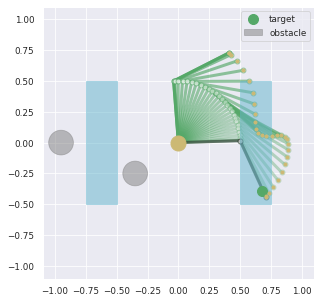

In [13]:
x_obst_np = [x.numpy() for x in x_obst]
link_lengths_np = link_lengths.numpy()
rect_patch = [[x_min_pick,y_min_pick, x_max_pick-x_min_pick,  y_max_pick-y_min_pick],
              [x_min_place,y_min_place, x_max_place-x_min_place,  y_max_place-y_min_place]]
plt=plot_chain(joint_loc=joint_loc, link_lengths=link_lengths_np, x_obst=x_obst_np, r_obst=r_obst, rect_patch=rect_patch, x_target=x_target, 
       batch=True, figsize=5, skip_frame=2, title=None, save_as=None, color_intensity=0.9, motion=True, alpha=0.8, 
           contrast=0.4, idx_highlight=[int(joint_loc.shape[0]-1)], lw=3, task=task)
# plt.savefig("reach-2d-tt-opt-7.png",dpi=300, pad_inches=0.01)

In [14]:
list(range(3))

[0, 1, 2]